In [2]:
import boto3
import json
import os
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dotenv import load_dotenv
import logging

# Load environment variables
load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Imports successful")

✓ Imports successful


In [3]:
def get_opensearch_client():
    """Initialize OpenSearch client with AWS authentication"""
    try:
        opensearch_host = os.environ.get('OPENSEARCH_CLUSTER_HOST')
        if not opensearch_host:
            raise ValueError("OPENSEARCH_CLUSTER_HOST environment variable not set")
        
        opensearch_host = opensearch_host.replace('https://', '').replace('http://', '').strip()
        
        # Load AWS credentials from environment
        aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
        aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
        aws_session_token = os.environ.get('AWS_SESSION_TOKEN')
        aws_region = os.environ.get('AWS_REGION', 'us-east-1')
        
        if not aws_access_key_id or not aws_secret_access_key:
            raise ValueError("AWS credentials not set in environment")
        
        session = boto3.Session(
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            aws_session_token=aws_session_token,
            region_name=aws_region
        )
        credentials = session.get_credentials()
        
        auth = AWSV4SignerAuth(credentials, aws_region, 'es')
        
        client = OpenSearch(
            hosts=[{'host': opensearch_host, 'port': 443}],
            http_auth=auth,
            use_ssl=True,
            verify_certs=True,
            connection_class=RequestsHttpConnection,
            pool_maxsize=20
        )
        
        logger.info(f"✓ Connected to OpenSearch at {opensearch_host}")
        return client
        
    except Exception as e:
        logger.error(f"✗ Failed to connect to OpenSearch: {e}")
        raise

# Test connection
client = get_opensearch_client()
print("✓ OpenSearch client initialized")

INFO:__main__:✓ Connected to OpenSearch at search-condenast-aos-domain-3hmon7me6ct3p5e46snecxe6f4.us-east-1.es.amazonaws.com


✓ OpenSearch client initialized


In [4]:
def fetch_all_embeddings(client, index_name="video_clips_consolidated", batch_size=1000):
    """Fetch all visual-text embeddings from OpenSearch"""
    logger.info(f"Fetching embeddings from index: {index_name}")
    
    embeddings = []
    metadata = []
    
    # Use scroll API to fetch all documents
    search_body = {
                "query": {"match_all": {}},
                "size": batch_size
            }
    
    try:
        # Initial search
        response = client.search(index=index_name, body=search_body, scroll="2m")
        scroll_id = response.get('_scroll_id')
        
        total_hits = response['hits']['total']['value']
        logger.info(f"Total clips found: {total_hits}")
        
        # Process initial batch
        for hit in response['hits']['hits']:
            source = hit['_source']
            embedding = source.get('emb_vis_text', [])
            
            if embedding and len(embedding) > 0:
                embeddings.append(embedding)
                metadata.append({
                    'clip_id': source.get('clip_id'),
                    'video_id': source.get('video_id'),
                    'clip_text': source.get('clip_text', '')[:50],  # First 50 chars
                    'timestamp_start': source.get('timestamp_start', 0)
                })
        
        # # Process remaining batches using scroll
        # while scroll_id:
        #     response = client.transport.perform_request(
        #         "GET",
        #         "/_search/scroll",
        #         body=json.dumps({"scroll": "2m", "scroll_id": scroll_id})
        #     )
            
        #     scroll_id = response.get('_scroll_id')
        #     hits = response.get('hits', {}).get('hits', [])
            
        #     if not hits:
        #         break
            
        #     for hit in hits:
        #         source = hit['_source']
        #         embedding = source.get('emb_vis_text', [])
                
        #         if embedding and len(embedding) > 0:
        #             embeddings.append(embedding)
        #             metadata.append({
        #                 'clip_id': source.get('clip_id'),
        #                 'video_id': source.get('video_id'),
        #                 'clip_text': source.get('clip_text', '')[:50],
        #                 'timestamp_start': source.get('timestamp_start', 0)
        #             })
        
        logger.info(f"✓ Fetched {len(embeddings)} embeddings")
        return np.array(embeddings), metadata
        
    except Exception as e:
        logger.error(f"✗ Error fetching embeddings: {e}")
        raise

# Fetch embeddings
embeddings, metadata = fetch_all_embeddings(client)
print(f"✓ Loaded {len(embeddings)} embeddings")
print(f"  Embedding dimension: {embeddings.shape[1]}")

INFO:__main__:Fetching embeddings from index: video_clips_consolidated
INFO:opensearch:POST https://search-condenast-aos-domain-3hmon7me6ct3p5e46snecxe6f4.us-east-1.es.amazonaws.com:443/video_clips_consolidated/_search?scroll=2m [status:200 request:130.061s]
INFO:__main__:Total clips found: 134
INFO:__main__:✓ Fetched 134 embeddings


✓ Loaded 134 embeddings
  Embedding dimension: 1024


In [5]:
# Apply t-SNE dimensionality reduction
logger.info("Applying t-SNE dimensionality reduction...")
logger.info("This may take a few minutes depending on the number of embeddings...")

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    verbose=1
)

embeddings_2d = tsne.fit_transform(embeddings)
logger.info(f"✓ t-SNE completed. Shape: {embeddings_2d.shape}")

# Create DataFrame for easier handling
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'clip_id': [m['clip_id'] for m in metadata],
    'video_id': [m['video_id'] for m in metadata],
    'clip_text': [m['clip_text'] for m in metadata],
    'timestamp_start': [m['timestamp_start'] for m in metadata]
})

print(f"✓ Created DataFrame with {len(df)} rows")
print(df.head())

INFO:__main__:Applying t-SNE dimensionality reduction...
INFO:__main__:This may take a few minutes depending on the number of embeddings...


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.006s...


[t-SNE] Computed neighbors for 134 samples in 55.602s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 0.335356
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.742027


INFO:__main__:✓ t-SNE completed. Shape: (134, 2)


[t-SNE] KL divergence after 1000 iterations: 0.137132
✓ Created DataFrame with 134 rows
          x          y                clip_id  \
0 -1.553069  10.073277  clip_24d7bc171cdb5d50   
1 -2.036808   8.545251  clip_9410c9f35b8cd24d   
2 -2.128588   8.504636  clip_29e1148639948951   
3 -0.397062   7.945886  clip_93c308456312b7f3   
4  0.656588   7.570557  clip_ef375db4ea179326   

                               video_id                      clip_text  \
0  5007115d-0c33-4b95-8595-958ecfa36a7b  The Dancer Director s Cut.mp4   
1  5007115d-0c33-4b95-8595-958ecfa36a7b  The Dancer Director s Cut.mp4   
2  5007115d-0c33-4b95-8595-958ecfa36a7b  The Dancer Director s Cut.mp4   
3  5007115d-0c33-4b95-8595-958ecfa36a7b  The Dancer Director s Cut.mp4   
4  5007115d-0c33-4b95-8595-958ecfa36a7b  The Dancer Director s Cut.mp4   

   timestamp_start  
0              9.9  
1             32.2  
2             37.4  
3             48.3  
4             55.5  


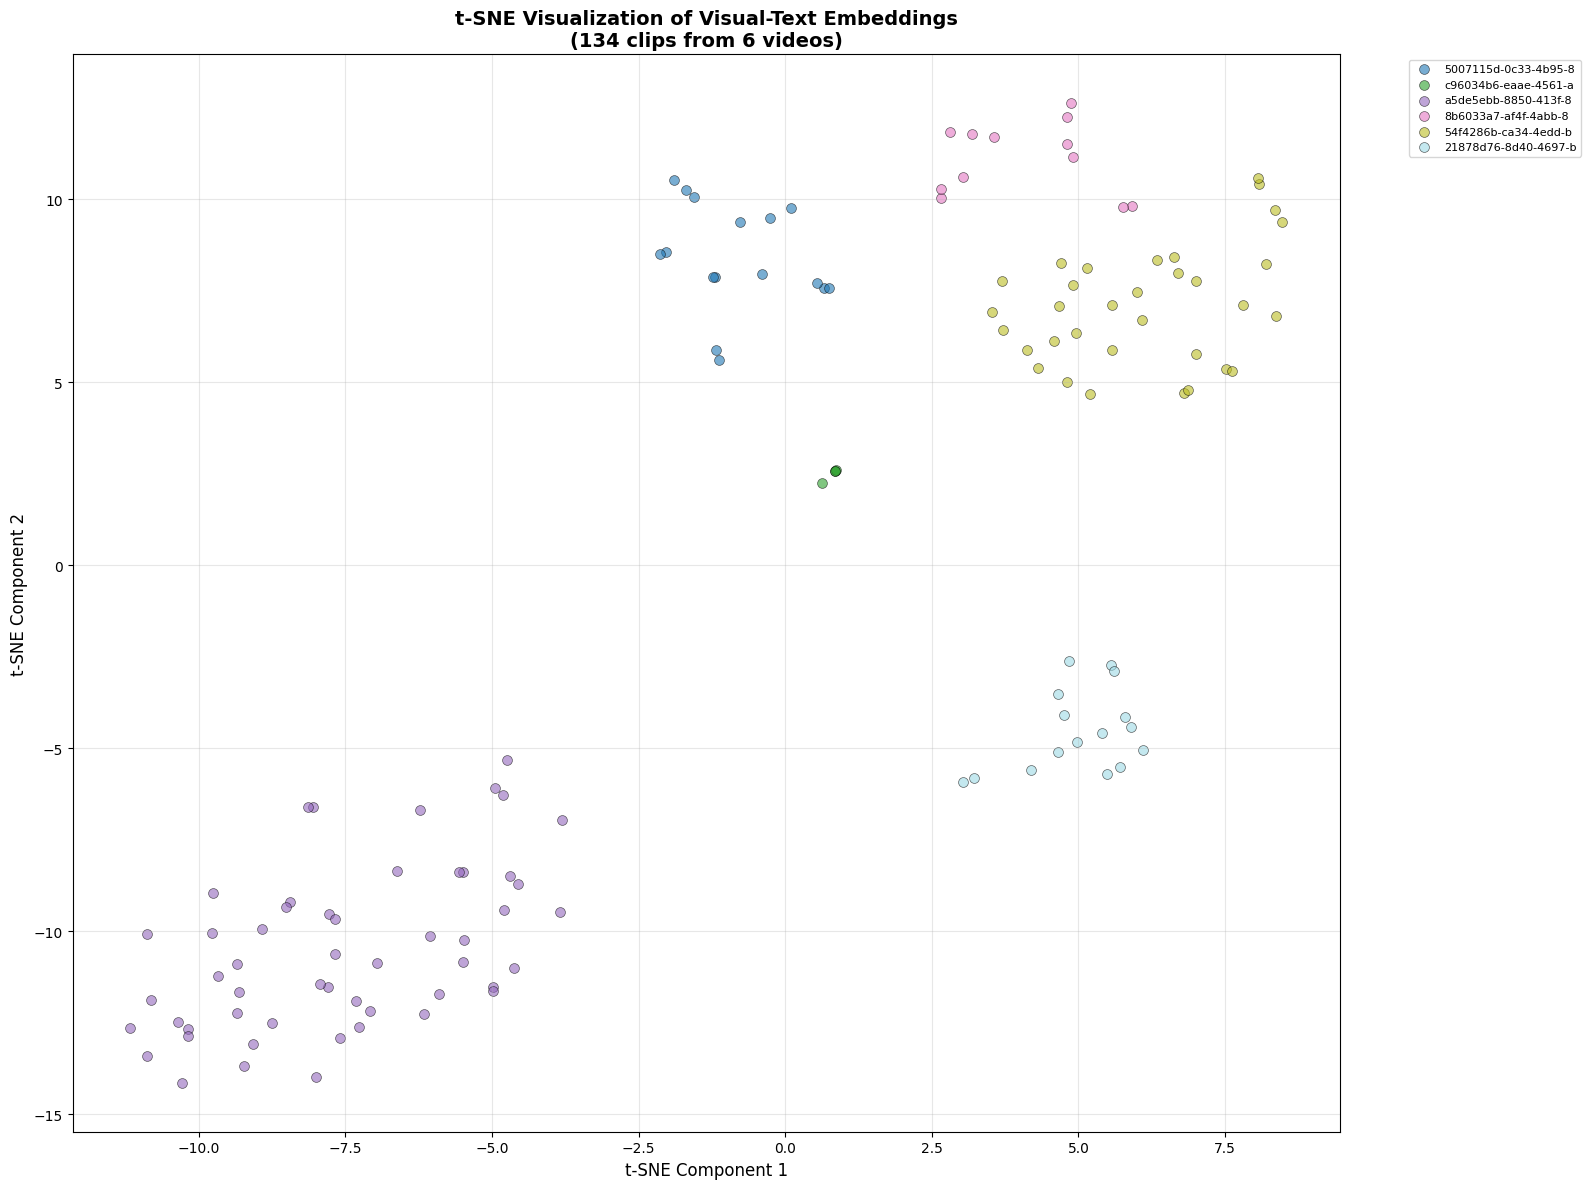

✓ Visualization saved as 'tsne_embeddings_visualization.png'


In [9]:
# Create interactive visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Color by video_id for better visualization
unique_videos = df['video_id'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_videos)))
video_colors = {vid: colors[i] for i, vid in enumerate(unique_videos)}

# Plot each video with different color
for video_id in unique_videos:
    mask = df['video_id'] == video_id
    ax.scatter(
        df[mask]['x'],
        df[mask]['y'],
        c=[video_colors[video_id]],
        label=video_id[:20],  # Truncate long names
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('t-SNE Component 1', fontsize=12)
ax.set_ylabel('t-SNE Component 2', fontsize=12)
ax.set_title(f't-SNE Visualization of Visual-Text Embeddings\n({len(df)} clips from {len(unique_videos)} videos)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_embeddings_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'tsne_embeddings_visualization.png'")

In [7]:
# Create interactive Plotly visualization
import plotly.graph_objects as go

fig = go.Figure()

# Get unique videos
unique_videos = df['video_id'].unique()
colors_plotly = [f'hsl({i * 360 / len(unique_videos)}, 70%, 50%)' for i in range(len(unique_videos))]
video_colors_plotly = {vid: colors_plotly[i] for i, vid in enumerate(unique_videos)}

# Add traces for each video
for video_id in unique_videos:
    mask = df['video_id'] == video_id
    subset = df[mask]
    
    fig.add_trace(go.Scatter(
        x=subset['x'],
        y=subset['y'],
        mode='markers',
        name=video_id[:30],
        marker=dict(
            size=8,
            color=video_colors_plotly[video_id],
            opacity=0.7,
            line=dict(width=1, color='white')
        ),
        text=[f"<b>{row['clip_id']}</b><br>" +
              f"Video: {row['video_id']}<br>" +
              f"Text: {row['clip_text']}<br>" +
              f"Timestamp: {row['timestamp_start']:.2f}s"
              for _, row in subset.iterrows()],
        hovertemplate='%{text}<extra></extra>',
        customdata=subset.index
    ))

fig.update_layout(
    title=f't-SNE Visualization of Visual-Text Embeddings ({len(df)} clips)',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    hovermode='closest',
    width=1400,
    height=900,
    showlegend=True,
    legend=dict(x=1.02, y=1, xanchor='left', yanchor='top')
)

fig.show()
print("✓ Interactive visualization created")

✓ Interactive visualization created


In [10]:
# Print statistics
print("=" * 60)
print("EMBEDDING VISUALIZATION STATISTICS")
print("=" * 60)
print(f"\nTotal Clips: {len(df)}")
print(f"Unique Videos: {df['video_id'].nunique()}")
print(f"\nClips per Video:")
clips_per_video = df['video_id'].value_counts()
for video_id, count in clips_per_video.head(10).items():
    print(f"  {video_id[:40]}: {count} clips")

if len(clips_per_video) > 10:
    print(f"  ... and {len(clips_per_video) - 10} more videos")

print(f"\nTimestamp Range:")
print(f"  Min: {df['timestamp_start'].min():.2f}s")
print(f"  Max: {df['timestamp_start'].max():.2f}s")
print(f"  Mean: {df['timestamp_start'].mean():.2f}s")

print(f"\nt-SNE Coordinates Range:")
print(f"  X: [{df['x'].min():.2f}, {df['x'].max():.2f}]")
print(f"  Y: [{df['y'].min():.2f}, {df['y'].max():.2f}]")

print("\n" + "=" * 60)

EMBEDDING VISUALIZATION STATISTICS

Total Clips: 134
Unique Videos: 6

Clips per Video:
  a5de5ebb-8850-413f-803e-848bdf2c394b: 53 clips
  54f4286b-ca34-4edd-bccf-85f26ca57021: 33 clips
  21878d76-8d40-4697-bc5a-9bec339ed862: 16 clips
  5007115d-0c33-4b95-8595-958ecfa36a7b: 16 clips
  8b6033a7-af4f-4abb-89dc-6563926dc6ce: 12 clips
  c96034b6-eaae-4561-ae41-ab6c72fa326c: 4 clips

Timestamp Range:
  Min: 0.00s
  Max: 330.20s
  Mean: 95.34s

t-SNE Coordinates Range:
  X: [-11.17, 8.48]
  Y: [-14.13, 12.62]

